### Imports

In [2]:
import math
from timeit import default_timer as timer

import bayesfunc as bf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
from torch.distributions import Categorical, Normal
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from data import REGRESSION_CONFIG, RegressionDataset

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
matplotlib.style.use('default')
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


Check to move to GPU and fix seed for reproducibility

In [5]:
t.cuda.is_available()
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
print(device)

t.manual_seed(0)

cuda:0


# Data generation

## Regression

In [6]:
params = REGRESSION_CONFIG

data_params = {
        'train': {
            'size': 40,
            'l_lim': 0.0,
            'u_lim': 0.5},
        'test': {
            'size': 40,
            'l_lim': -0.2,
            'u_lim': 1.4
            }
        }

# Generate data
num_training_pts = params.batch_size
regression_type = 1
dtype=t.float64
train_dataset = RegressionDataset(**data_params['train'], type=regression_type)
test_dataset = RegressionDataset(**data_params['test'], type=regression_type)

train_loader = DataLoader(train_dataset, **(params.dataloader))
test_loader = DataLoader(test_dataset, **(params.dataloader))


# Model specification 

BNN specification

In [65]:
# Set inducing set U_0
inducing_batch = 100
inducing_data, inducing_targets = next(iter(train_loader))
 
# for classification
# inducing_targets = (t.arange(num_classes) == inducing_targets[:, None]).float()

# Initialize to first <inducing_batch> training samples
if inducing_batch < inducing_data.shape[0]:
    inducing_data = inducing_data[:inducing_batch]
    inducing_targets = inducing_targets[:inducing_batch]

# Fill up inducing set with random initialized points on [0,1] if batch smaller than num inducing pts
if inducing_batch > inducing_data.shape[0]:
    inducing_data = t.cat([inducing_data, t.randn(inducing_batch-inducing_data.shape[0], *inducing_data.shape[1:], dtype=inducing_data.dtype)], 0)
    
    inducing_targets = t.cat(
        [inducing_targets, t.randn(inducing_batch - inducing_targets.shape[0], *inducing_targets.shape[1:], dtype=inducing_targets.dtype)], 0)
in_features = inducing_data.shape[-1]

In [53]:
# Uniform initialization on [-4, 4]
# inducing_batch = 40 # can be any shape
# inducing_data = t.linspace(-0.2, 1.4, inducing_batch)[:, None] # only useful to init on top of training data (which this doesn't)

# could also set to first batch of training data
# inducing_batch = 32 # must be equal to train_loader batch size
# inducing_data, inducing_targets = next(iter(train_loader))
# assert inducing_batch = inducing_data.shape[0]

# could also set to first batch of training data; below is for CIFAR
# inducing_data, inducing_targets = next(iter(train_loader))
# inducing_targets = (t.arange(num_classes) == inducing_targets[:, None]).float() 

## BNN

In [54]:
from bayesfunc.priors import InsanePrior, NealPrior

optional_layer_params = {
    # 'bias': True,
    'prior': NealPrior, #InsanePrior,
    #'inducing_targets': initial value of inducing targets (default None)
    'log_prec_init': -4, # initial precision parameter values; default -4, assumes little data available
    'log_prec_lr': 1, # LR multiplier for precision params
    # 'inducing_targets': inducing_targets
}

hidden_units=50
bnn_net = nn.Sequential(
    bf.GILinear(in_features=1, out_features=hidden_units, inducing_batch=inducing_batch, bias=True, **optional_layer_params),
    nn.ReLU(),
    bf.GILinear(in_features=hidden_units, out_features=hidden_units, inducing_batch=inducing_batch, bias=True, **optional_layer_params),
    nn.ReLU(),
    bf.GILinear(in_features=hidden_units, out_features=1, inducing_batch=inducing_batch, bias=True, full_prec=True, **optional_layer_params)
)

# Wrap model in inducing wrapper
in_features = 1
# bnn_net = bf.InducingWrapper(bnn_net, inducing_shape=(inducing_batch, in_features), inducing_batch=inducing_batch)
bnn_net = bf.InducingWrapper(bnn_net, inducing_data=inducing_data, inducing_batch=inducing_batch)
# Send to GPU
bnn_net = bnn_net.to(device=device, dtype=dtype)

## MFVI

In [8]:
hidden_units=50
mfvi_net = nn.Sequential(
    bf.FactorisedLinear(in_features=1, out_features=hidden_units, bias=True),
    nn.ReLU(),
    bf.FactorisedLinear(in_features=hidden_units, out_features=hidden_units, xbias=True),
    nn.ReLU(),
    bf.FactorisedLinear(in_features=hidden_units, out_features=1, bias=True)
)
mfvi_net = mfvi_net.to(device=device, dtype=dtype)

# Train

In [142]:
def train(net, train_loader, epoch, scale, factor, num_samples=10, plot=False):
    iters = 0
    total_elbo = 0.
    total_ll = 0.
    total_KL = 0.
    total_error = 0.

    # Tempered beta to have loss not be KL divergence (to optimize eval performance)
    temper = False
    L = 1. # temperature scaling
    tempered_beta = 0.1*math.floor((epoch-1)/10.)/L if (temper and epoch < 100) else 1/L
    beta = 1/L

    for data, target in train_loader:
        opt.zero_grad() # zero out the gradient (Torch accumulates across epochs otherwise)
        
        data, target = data.to(device), target.to(device)
        data = data.expand(num_samples, *data.shape) # make it S x N x D
        
        outputs, logPQw, _ = bf.propagate(net, data)
        
        # Classification: compute log likelihood estimate via outputs 
        # dist| = Categorical(logits=outputs)
        # ll = dist.log_prob(target).mean() 
        
        def log_s2():
            return scale*factor

        # Regression:
        sigma = t.exp(0.5*log_s2())
        ll = Normal(outputs.to(device), sigma).log_prob(target) # [10, batch size, output] => need to take mean across inference samples (first dim)
        ll = ll.mean(0)
        ll = ll.sum() # across batch size
        
        # Compute objectives
        nloss = ll.mean() + tempered_beta * logPQw.mean()/ num_training_pts  # tempered ELBO
        elbo = ll + beta * (logPQw / num_training_pts)

        (-elbo.mean()).backward()  
        opt.step()

        # For classification only
        # output = outputs.log_softmax(-1).logsumexp(0) - math.log(outputs.shape[0])
        # pred = output.argmax(dim=-1, keepdim=True)
        # correct = pred.eq(target.view_as(pred)).float().mean()
        
        error = (outputs.mean() - target) # regression, y = f(x) + e => e distrib Gaussian
                
        iters         += 1
        total_elbo    += elbo.mean().item()
        total_ll      += ll.mean().item()
        total_KL      -= (beta*logPQw.mean()/num_training_pts).item()
        total_error   += error.sum()

    return (total_elbo/iters, total_ll/iters, total_KL/iters, total_error/iters)

In [77]:
net = bnn_net
loader = train_loader

lr = 0.05
factor=10
log_s2_scaled = t.tensor(-3./factor, requires_grad=True, device=device)
opt = t.optim.Adam([*net.parameters(), log_s2_scaled], lr=lr)
scheduler = ExponentialLR(opt, gamma=0.95)
epochs = 1000

epoch = []
train_elbo = []
train_ll = []
train_KL = []
test_ll = []
train_err = []

pbar = tqdm(range(epochs), position=0, leave=True)
start_time = timer()
prev_time = timer()
for _epoch in pbar:
    
    _elbo, _train_ll, _train_KL, _train_err = train(net, loader, _epoch, log_s2_scaled, factor)

    if _epoch % 100 == 0: scheduler.step()

    epoch.append(_epoch)
    train_elbo.append(_elbo)
    train_ll.append(_train_ll)
    train_KL.append(_train_KL)
    train_err.append(_train_err)
    
    # with t.no_grad():
    #     _test_ll, _test_correct = test()
    # test_ll.append(_test_ll)
    # test_correct.append(_test_correct)

    if _epoch%10 == 0:
        report_time = timer() - prev_time
        prev_time += report_time
        total_time = timer() - start_time

        report = f"epoch: {_epoch:03d}, time: {report_time: 3.2f} (total {total_time:3.2f}), elbo: {_elbo:.3f}, KL: {_train_KL:.3f}, err: {_train_err:.3f}"
        pbar.set_description(report)

        # print(f"epoch: {_epoch:03d}, time: {report_time: 3.2f} (total {total_time:3.2f}), elbo: {_elbo:.3f}, KL: {_train_KL:.3f}, err: {_train_err:.3f}", flush=True)
    
print(train_elbo[-1])

epoch: 990, time:  0.14 (total 13.57), elbo: 25.249, KL: 12.256, err: 0.161: 100%|██████████| 1000/1000 [00:13<00:00, 73.05it/s]

31.17583203138678


# Plot

In [123]:
def plot(net, test_loader: DataLoader=None, num_inference_samples=10):
    xs = []
    targets = []
    preds = []
    stds = []

    with t.no_grad(): # no grad computation

        for data, target in test_loader:

            data, target = data.to(device), target.to(device)
            reshaped_data = data.expand(num_inference_samples, *data.shape) # make it S x N x D
        
            outputs, logPQw, sample_dict = bf.propagate(bnn_net, reshaped_data)
            
            pm = outputs.mean(0).flatten().cpu() 
            ps = outputs.std(0).flatten().cpu()

            xs.append(data)
            targets.append(target)
            preds.append(pm)
            stds.append(ps)


        xs = t.cat(xs, dim=1).cpu() # shape: inference_samples x batch_size/N x 1
        xs = xs.flatten()
        preds = t.cat(preds, dim=0).cpu()
        targets = t.cat(targets, dim=1).cpu() # shape: N x 1
        targets = targets.flatten()
        stds = t.cat(stds, dim=0).cpu()

        # Sort in same order
        xs, preds, targets, stds = (np.array(t) for t in zip(*sorted(zip(xs, preds, targets, stds))))

        plt.fill_between(xs, preds-2*stds, preds+2*stds, alpha=0.5)
        plt.plot(xs, preds, label='Prediction mean')
        plt.scatter(xs, targets, label='True values')
        plt.show()

        return xs, preds, targets, stds

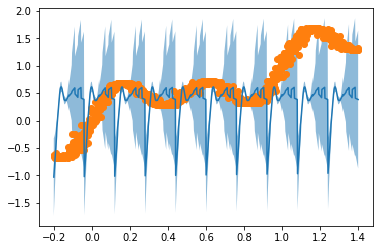

In [133]:
xs, preds, targets, stds = plot(bnn_net, test_loader)

torch.Size([100, 1])


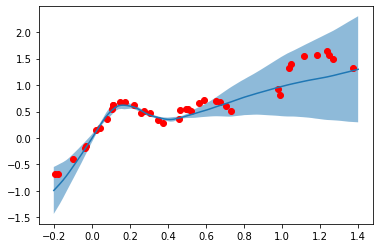

In [78]:
X, y = next(iter(test_loader))
plot_b(bnn_net, X, y)

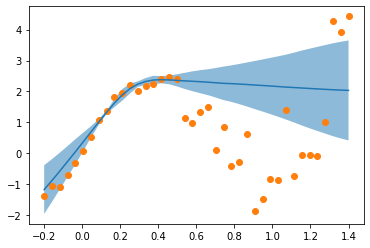

In [44]:
plot(bnn_net, test_loader)

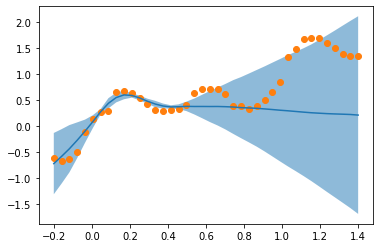

In [126]:
plot(bnn_net, test_loader)

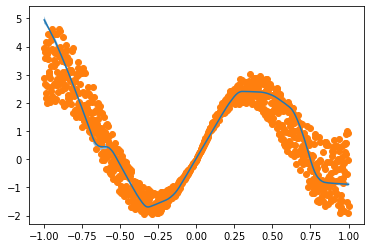

In [114]:
lb = -1
ub = 1
xs = np.linspace(lb,ub,1000)
ys = regression3(xs)
xs = t.tensor(xs).unsqueeze(1)
ys = t.tensor(ys).unsqueeze(1)
plot(bnn_net, [(xs, ys)])

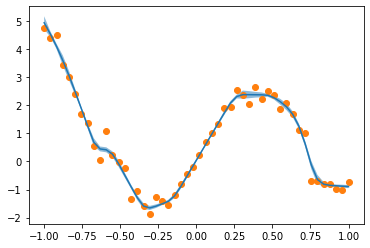

In [116]:
plot(bnn_net, train_loader)

torch.Size([100, 1])


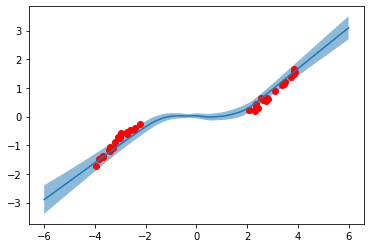

In [17]:
plot(mfvi_net)

torch.Size([100, 1])


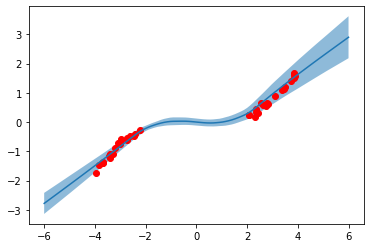

In [14]:
plot(mfvi_net)

# Simple

In [134]:
# Simple notebook example

def train_b(net, X, y, num_samples, lr, epochs):
    opt = t.optim.Adam(net.parameters(), lr=lr)
    samples = num_samples
    for i in range(epochs):
        
        opt.zero_grad() # zero out the gradient bc Torch accumulates the gradients on subsequent backward passes
        
        # get network output (calls net.forward) and logpq
        output, logpq, sample_dict = bf.propagate(net, X.expand(samples, -1, -1)) # create X: S x N x D
        ll = Normal(output.to(device), 3/scale.to(device)).log_prob(y).sum(-1).mean(-1)  # log-likelihood
        
        assert ll.shape == (samples,)
        assert logpq.shape == (samples,)
        
        elbo = ll + logpq/num_training_pts
        (-elbo.mean()).backward()
        
        opt.step()
        if i%100==0: 
            print(f"epoch: {i}, elbo: {elbo.mean().item()}")
            plt.scatter(X.flatten().cpu().detach(), output[0, :].flatten().cpu().detach())
            plt.scatter(X.flatten().cpu().detach(), y.flatten().cpu().detach())
            plt.show()
            
    print(elbo.mean().item())

def plot_b(net, X, y, lb=-4, ub=4, num_inference_samples=10):

    with t.no_grad():
        xs = t.linspace(lb,ub,100)[:, None].to(device=device, dtype=dtype)

        ys, _, _ = bf.propagate(net, xs.expand(num_inference_samples, -1, -1))
        mean_ys = ys.mean(0)
        std_ys = ys.std(0)
        plt.fill_between(xs[:, 0].cpu(), mean_ys[:, 0].cpu()-2*std_ys[:, 0].cpu(), mean_ys[:, 0].cpu()+2*std_ys[:, 0].cpu(), alpha=0.5)
        plt.plot(xs.cpu(), mean_ys.cpu())
        plt.scatter(X.cpu(), y.cpu(), c='r')